<a href="https://colab.research.google.com/github/Ixiondbz/CSE499/blob/main/MIDOG_ObjectDetecton_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIDOG Challenge

This is an example notebook for the [MIDOG Challenge](https://imi.thi.de/midog/) to support you in your first steps with the data. First, general data analysis is presented, and then a RetinaNet is trained on the data. The data is loaded from a shared google drive folder. 

To see the code please **double click** on the cells. 

All relevant variables for the notebook are [form parameters](https://colab.research.google.com/notebooks/forms.ipynb). We encourage you to play around with the parameters like source and target scanner or learning rate values. 

In [ ]:
#@title Import some python packages { vertical-output: true, display-mode: "form" }

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install -U plotly

import json
from pathlib import Path
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from tqdm import tqdm
import pandas as pd
import random
import cv2

In [ ]:
from google.colab import drive
drive.mount('/drive')

folder = "MyDrive/MIDOG_Challenge" #@param {type:"string"}
midog_folder = Path("/drive") / Path(folder)

print(list(midog_folder.glob("*.*")))

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
[PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.sqlite'), PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.json')]


In [ ]:
!apt-get install python3-openslide
from openslide import open_slide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-2ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## Object detection library and data exploration

For object detection on whole slide images (WSI), we use code from this  https://github.com/ChristianMarzahl/ObjectDetection repository.
If you are using the repository or parts thereof, please cite the corresponding [paper](https://www.nature.com/articles/s41598-020-65958-2):

```
@article{marzahl2020deep,
  title={Deep learning-based quantification of pulmonary hemosiderophages in cytology slides},
  author={Marzahl, Christian and Aubreville, Marc and Bertram, Christof A and Stayt, Jason and Jasensky, Anne-Katherine and Bartenschlager, Florian and Fragoso-Garcia, Marco and Barton, Ann K and Elsemann, Svenja and Jabari, Samir and Jens, Krauth and Prathmesh, Madhu and Jörn, Voigt and Jenny, Hill and Robert, Klopfleisch and Andreas, Maier },
  journal={Scientific Reports},
  volume={10},
  number={1},
  pages={1--10},
  year={2020},
  publisher={Nature Publishing Group}
}
```

In [ ]:
!pip install -U object-detection-fastai

from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBMetrics, PascalVOCMetricByDistance, PascalVOCMetric, PascalVOCMetricByDistance

In [ ]:
image_folder = midog_folder / "images"

hamamatsu_rx_ids = list(range(0, 51))
hamamatsu_360_ids = list(range(51, 101))
aperio_ids = list(range(101, 151))
leica_ids = list(range(151, 201))

In [ ]:
annotation_file = midog_folder / "MIDOG.json"
rows = []
with open(annotation_file) as f:
    data = json.load(f)

    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        scanner  = "Hamamatsu XR"
        if image_id in hamamatsu_360_ids:
            scanner  = "Hamamatsu S360"
        if image_id in aperio_ids:
            scanner  = "Aperio CS"
        if image_id in leica_ids:
            scanner  = "Leica GT450"
         
        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]

            rows.append([file_name, image_id, width, height, box, cat, scanner])

df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "scanner"])
df.head()

### Statistics
The following examples will give you an idea regarding the distribution of mitotic figure annotations and hard examples in the data across the different scanners.

#### **Please be aware that only the mitotic figures are relevant for the challenge.**
The hard negatives (non-mitotic cell) annotations are only meant to visualise the problem.



In [ ]:
pie_df = pd.DataFrame([
          ["mitotic figure", len(df[df["cat"] == "mitotic figure"])],
          ["hard negative", len(df[df["cat"] == "hard negative"])]], columns=["cat", "total"])

fig = px.pie(pie_df, values='total', names='cat', title='Mitotic figures vs hard negatives')
fig.show()

In [ ]:
for scanner in df['scanner'].unique():

    scanner_annos = df[df['scanner'] == scanner]

    row = []
    for image_id in scanner_annos["image_id"].unique():
        image_annos = scanner_annos[scanner_annos["image_id"] == image_id]
        row.append([image_id, len(image_annos[image_annos['cat'] == 'mitotic figure']), "mitotic figure"])
        row.append([image_id, len(image_annos[image_annos['cat'] == 'hard negative']), "hard negative"])

    scanner_meta = pd.DataFrame(row, columns=["image_id", "total", "type"])

    fig = px.bar(scanner_meta, x="image_id", y="total", color="type", title=f"{scanner}: Annotations per image")
    fig.show()

### Visual Examples

In [ ]:
num_images_per_scanner = 5 #@param {type:"integer"}
thumbail_size =  512#@param {type:"integer"}

for scanner, ids in zip(["Hamamatsu XR", "Hamamatsu S360", "Aperio CS2", "Leica GT450"], [hamamatsu_rx_ids, hamamatsu_360_ids, aperio_ids, leica_ids]):

    imgs = []

    for image_id in tqdm(ids[:num_images_per_scanner]):

        image_id += 1

        file_path = image_folder / f"{image_id:03d}.tiff"

        if file_path.exists():
            slide = open_slide(str(file_path))
            img = slide.get_thumbnail((thumbail_size, thumbail_size))
            imgs.append(np.array(img))

    imgs = np.array(imgs)

    max_x = max([img.shape[1] for img in imgs])
    max_y = max([img.shape[0] for img in imgs])

    imgs = np.array([cv2.resize(img, dsize=(max_x, max_y)) for img in imgs])

    fig = px.imshow(imgs, facet_col=0, facet_col_wrap=5, labels={'facet_col':'Image'}, title=scanner)

    for i, id in enumerate(ids[:num_images_per_scanner]):
        fig.layout.annotations[i]['text'] = f'Image: {id}'

    fig.show()

In [ ]:
thumbail_size_big = 1024 #@param {type:"integer"}

image_id = 113  #@param {type:"slider", min:1, max:200, step:1}

slide = open_slide(str(image_folder / f"{image_id:03d}.tiff"))

image = slide.get_thumbnail((thumbail_size_big, thumbail_size_big))

fig = px.imshow(image)

scale_x = slide.level_dimensions[0][0] / image.size[0]
scale_y = slide.level_dimensions[0][1] / image.size[1]

for id, anno in df[df["image_id"] == image_id].iterrows():

    x0, y0, x1, y1 = anno.box[0] / scale_x, anno.box[1] / scale_y, anno.box[2] / scale_x, anno.box[3] / scale_y


    fig.add_shape(
        type='rect',
        x0=x0, x1=x1, y0=y0, y1=y1,
        xref='x', yref='y',
        line_color='red' if "mitotic" in anno["cat"] else "blue"
    )

fig.update_layout(
    autosize=False,
    width=image.size[0],
    height=image.size[1],
    )

fig.show()

In [ ]:
num_mitotic_figures_per_scanner = 10  #@param {type:"integer"}

for scanner, ids in zip(["Hamamatsu XR", "Hamamatsu S360", "Aperio CS2"], [hamamatsu_rx_ids, hamamatsu_360_ids, aperio_ids]):

    imgs = []

    for image_id in tqdm(ids):

        image_id += 1

        file_path = image_folder / f"{image_id:03d}.tiff"

        if file_path.exists():
            slide = open_slide(str(file_path))
            annotations = df[(df["file_name"] == f"{image_id:03d}.tiff") & (df["cat"] =="mitotic figure" )]

            for id, anno in annotations.iterrows():

                center_x, center_y = anno.box[0] + (anno.box[2] - anno.box[0]) / 2, anno.box[1] + (anno.box[3] - anno.box[1]) / 2
                img = np.array(slide.read_region((int(center_x-50), int(center_y-50)), level=0, size=(100, 100)))
                imgs.append(img)

                if len(imgs) == num_mitotic_figures_per_scanner:
                    break

        if len(imgs) == num_mitotic_figures_per_scanner:
            break

    fig = px.imshow(np.array(imgs), facet_col=0, facet_col_wrap=5, labels={'facet_col':'mitotic figure'}, title=scanner)
    fig.show()

In [ ]:
num_mitotic_figures_per_scanner = 10  #@param {type:"integer"}

for scanner, ids in zip(["Hamamatsu XR", "Hamamatsu S360", "Aperio CS2"], [hamamatsu_rx_ids, hamamatsu_360_ids, aperio_ids]):

    imgs = []

    for image_id in tqdm(ids):

        image_id += 1

        file_path = image_folder / f"{image_id:03d}.tiff"

        if file_path.exists():
            slide = open_slide(str(file_path))
            annotations = df[(df["file_name"] == f"{image_id:03d}.tiff") & (df["cat"] == "hard negative" )]

            for id, anno in annotations.iterrows():

                center_x, center_y = anno.box[0] + (anno.box[2] - anno.box[0]) / 2, anno.box[1] + (anno.box[3] - anno.box[1]) / 2
                img = np.array(slide.read_region((int(center_x-50), int(center_y-50)), level=0, size=(100, 100)))
                imgs.append(img)

                if len(imgs) == num_mitotic_figures_per_scanner:
                    break

        if len(imgs) == num_mitotic_figures_per_scanner:
            break

    fig = px.imshow(np.array(imgs), facet_col=0, facet_col_wrap=5, labels={'facet_col':'hard negative'}, title=scanner)
    fig.show()

# Finally some object detection!

After we have had a look at the data, we now want to guide you towards detecting mitotic figures using an object detection approach. Before we can train the object detection network, we need to set up the training procedure.

In [ ]:
def sample_function(y, classes, size, level_dimensions, level):
    width, height = level_dimensions[level]
    if len(y[0]) == 0:
        return randint(0, width - size[0]), randint(0, height -size[1])
    else:
        #if randint(0, 5) < 2:
        if True:
            class_id = np.random.choice(classes, 1)[0] # select a random class
            ids = np.array(y[1]) == class_id # filter the annotations according to the selected class
            xmin, ymin, _, _ = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)] # randomly select one of the filtered annotatons as seed for the training patch
            
            # To have the selected annotation not in the center of the patch and an random offset.
            xmin += random.randint(-size[0]/2, size[0]/2) 
            ymin += random.randint(-size[1]/2, size[1]/2)
            xmin, ymin = max(0, int(xmin - size[0] / 2)), max(0, int(ymin -size[1] / 2))
            xmin, ymin = min(xmin, width - size[0]), min(ymin, height - size[1])
            return xmin, ymin
        else:
            return randint(0, width - size[0]), randint(0, height -size[1])

In [ ]:
#@title Select a training and validation scanner { run: "auto", display-mode: "form" }

def create_wsi_container(annotations_df: pd.DataFrame):

    container = []

    for image_name in tqdm(annotations_df["file_name"].unique()):

        image_annos = annotations_df[annotations_df["file_name"] == image_name]

        bboxes = [box   for box   in image_annos["box"]]
        labels = [label for label in image_annos["cat"]]

        container.append(SlideContainer(image_folder/image_name, y=[bboxes, labels], level=res_level,width=patch_size, height=patch_size, sample_func=sample_function))

    return container

#@markdown Options can also be combined like:  Hamamatsu XR, Hamamatsu S360
train_scanner = "Hamamatsu XR" #@param ["Hamamatsu XR", "Hamamatsu S360", "Aperio CS"]  {allow-input: true}
val_scanner = "Hamamatsu S360" #@param ["Hamamatsu XR", "Hamamatsu S360", "Aperio CS"]  {allow-input: true}

patch_size = 256 #@param [256, 512, 1024]
res_level = 0

train_annos = df[df["scanner"].isin(train_scanner.split(","))]
train_container = create_wsi_container(train_annos)

val_annos = df[df["scanner"].isin(val_scanner.split(","))]
valid_container = create_wsi_container(val_annos)

f"Created: {len(train_container)} training WSI container and {len(valid_container)} validation WSI container"

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


'Created: 50 training WSI container and 50 validation WSI container'

In [ ]:
import numpy as np
train_samples_per_scanner = 50 #@param {type:"integer"}
val_samples_per_scanner = 10 #@param {type:"integer"}

train_images = list(np.random.choice(train_container, train_samples_per_scanner))
valid_images = list(np.random.choice(valid_container, val_samples_per_scanner))

In [ ]:
#@title We build on the [FastAI](https://www.fast.ai/) pipline. Please take a look a the [documentation](https://docs.fast.ai/) for more information. { run: "auto", display-mode: "form" }

batch_size = 12 #@param {type:"integer"}

#@markdown Lets add some basic data [augmentation](https://docs.fast.ai/vision.augment.html)
do_flip = True #@param {type:"boolean"}
flip_vert = True #@param {type:"boolean"}
max_rotate = 90 #@param {type:"number"}
max_zoom = 1.1 #@param {type:"number"}
max_lighting = 0.2 #@param {type:"number"}
max_warp = 0.2 #@param {type:"number"}
p_affine = 0.75 #@param {type:"number"}
p_lighting = 0.75 #@param {type:"number"}



tfms = get_transforms(do_flip=do_flip,
                      flip_vert=flip_vert,
                      max_rotate=max_rotate,
                      max_zoom=max_zoom,
                      max_lighting=max_lighting,
                      max_warp=max_warp,
                      p_affine=p_affine,
                      p_lighting=p_lighting)

train, valid = ObjectItemListSlide(train_images), ObjectItemListSlide(valid_images)
item_list = ItemLists(".", train, valid)
lls = item_list.label_from_func(lambda x: x.y, label_cls=SlideObjectCategoryList)
lls = lls.transform(tfms, tfm_y=True, size=patch_size)
data = lls.databunch(bs=batch_size, collate_fn=bb_pad_collate,num_workers=0).normalize()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning:

torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)



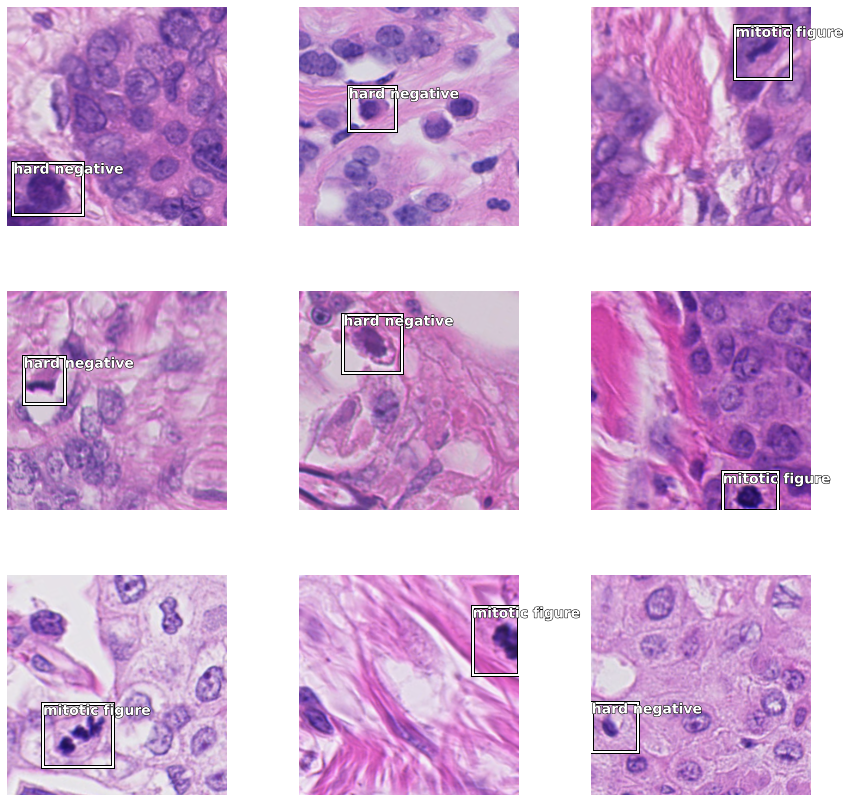

In [ ]:
rows = 3 #@param {type:"integer"}
figsize = 12 #@param {type:"integer"}
data.show_batch(rows=rows, ds_type=DatasetType.Train, figsize=(figsize, figsize))

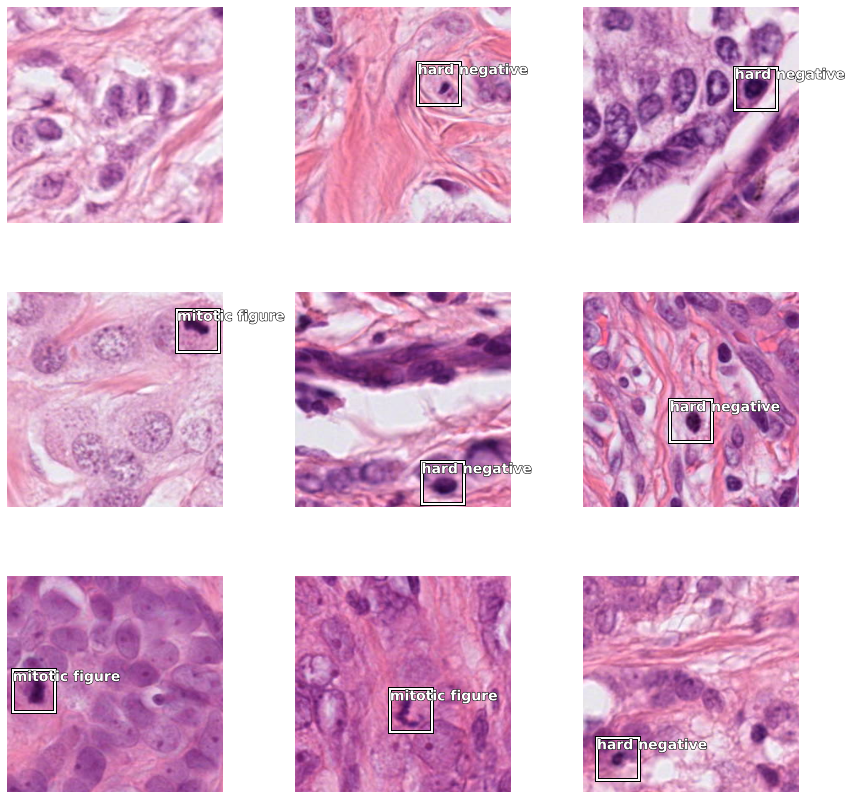

In [ ]:
rows = 3 #@param {type:"integer"}
figsize = 12 #@param {type:"integer"}

data.show_batch(rows=rows, ds_type=DatasetType.Valid, figsize=(figsize, figsize))

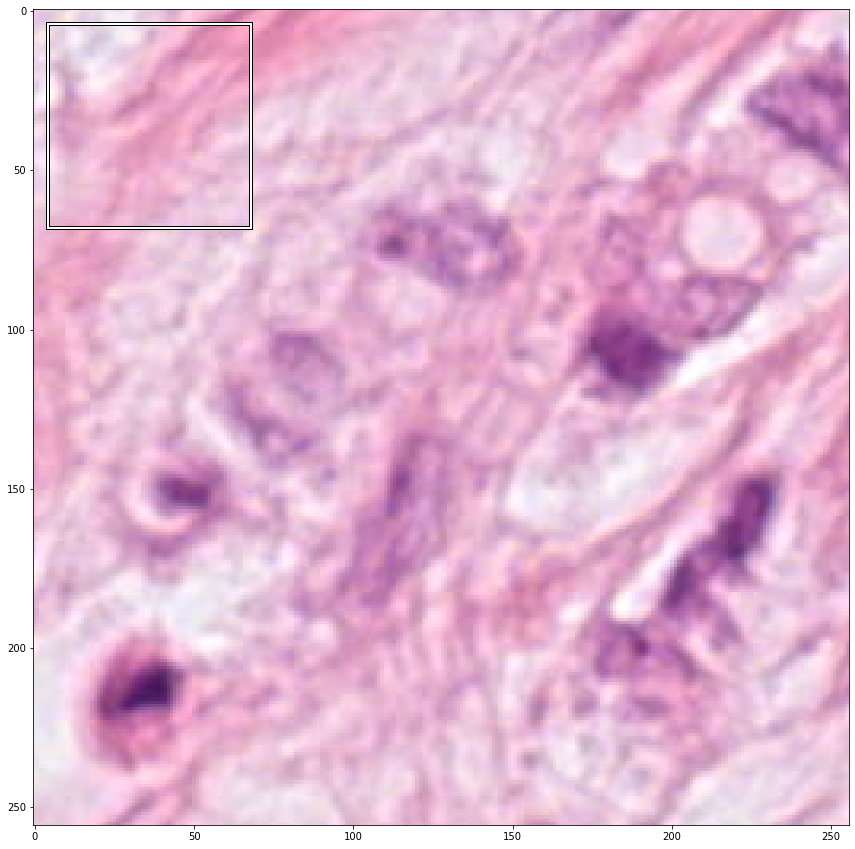

In [ ]:
scales = [2] #@param {type:"raw"}

ratios=[1]  #@param {type:"raw"}

sizes=[(32,32)] #@param {type:"raw"}

anchors = create_anchors(sizes=sizes, ratios=ratios, scales=scales)


fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:len(scales)*len(ratios)*len(sizes)]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * patch_size / 2 
    y = (bb[1] + 1) * patch_size / 2 
    w = bb[2] * patch_size / 2
    h = bb[3] * patch_size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)


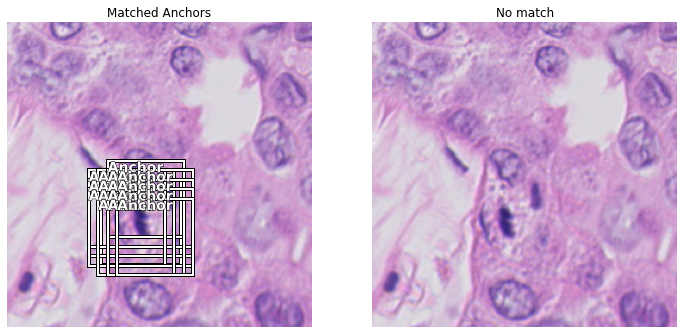

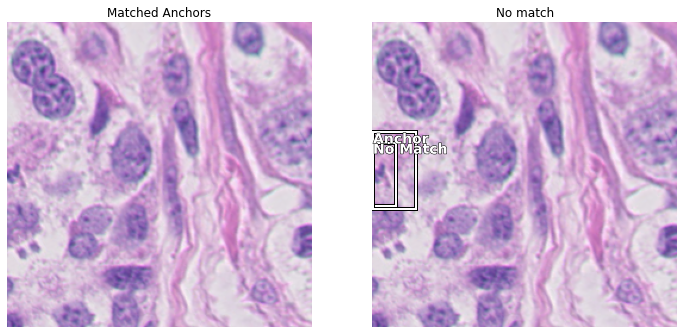

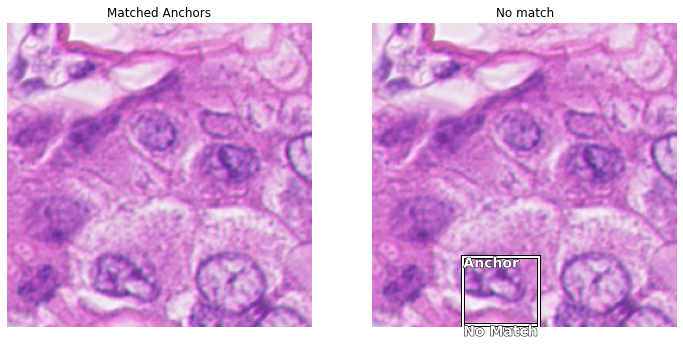

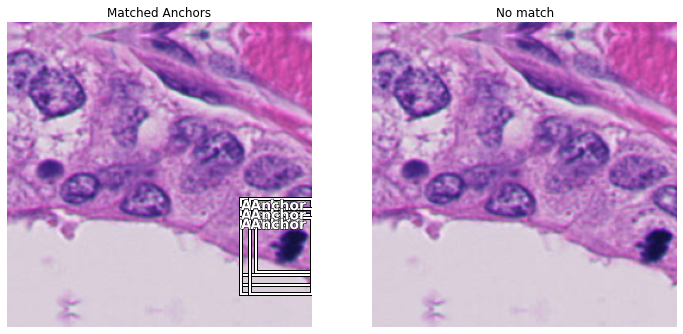

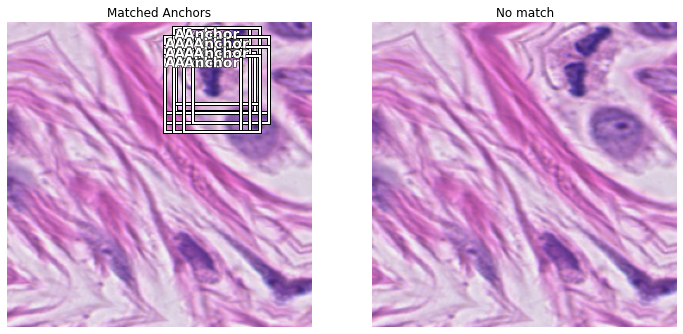

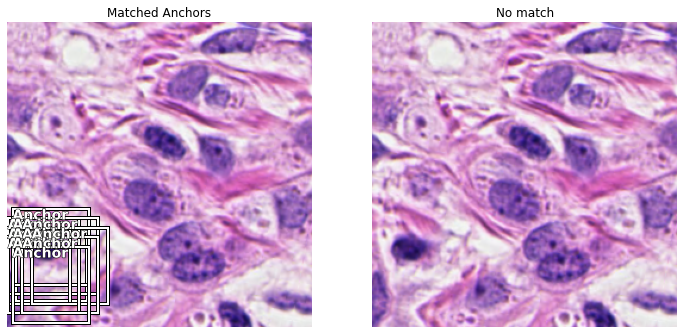

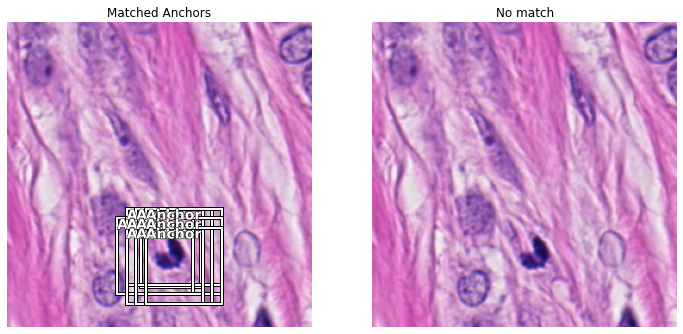

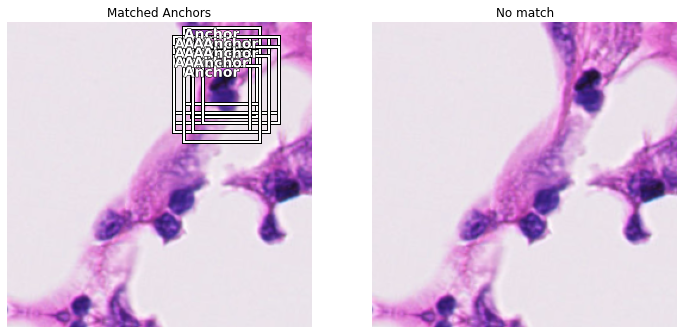

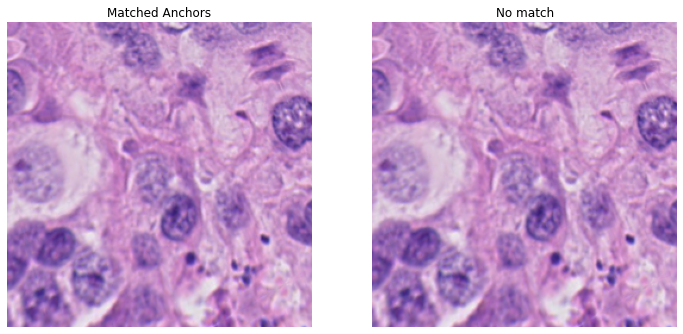

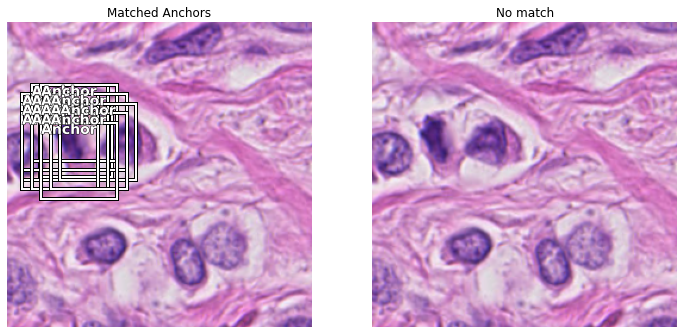

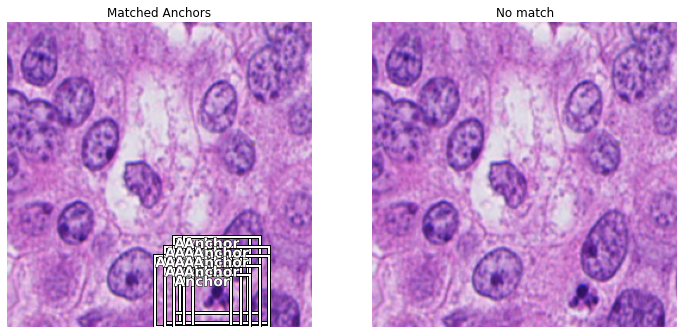

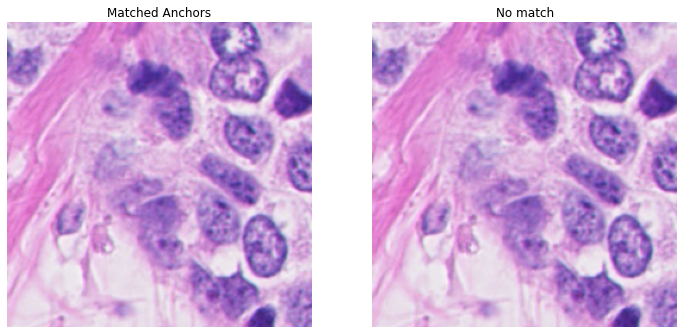

In [ ]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(12, 12))

## Training an object detection model
After we have set up these necessary prerequisites w.r.t. our training data, let's get the model itself ready for training.

In [ ]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.7.12
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.10.0+cu111
nvidia driver : 460.32
torch cuda    : 11.1 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Sat Jun 5 09:50:34 PDT 2021
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installe

In [ ]:
backbone = "ResNet18" #@param ["ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet150"]

backbone_model = models.resnet18
if backbone == "ResNet34":
    backbone_model = models.resnet34
if backbone == "ResNet50":
    backbone_model = models.resnet50
if backbone == "ResNet101":
    backbone_model = models.resnet101
if backbone == "ResNet150":
    backbone_model = models.resnet150

pre_trained_on_imagenet = True #@param {type:"boolean"}
encoder = create_body(models.resnet34, pre_trained_on_imagenet, -2)

loss_function = "FocalLoss"  #@param ["FocalLoss"]

if loss_function == "FocalLoss":
    crit = RetinaNetFocalLoss(anchors)

channels = 128 #@param {type:"integer"}

final_bias = -4 #@param {type:"number"}

n_conv = 3 #@param {type:"integer"}

model = RetinaNet(encoder, n_classes=data.train_ds.c, 
                  n_anchors=len(scales) * len(ratios), 
                  sizes=[size[0] for size in sizes], 
                  chs=channels, # number of hidden layers for the classification head
                  final_bias=final_bias, # Bias for the fully connected layers
                  n_conv=n_conv # Number of hidden layers
                  )

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
#@title To meassure the performance we use the [PascalVOCMetric](https://github.com/rafaelpadilla/review_object_detection_metrics) { vertical-output: true, display-mode: "form" }

voc = PascalVOCMetric(anchors, patch_size, [str(i) for i in data.train_ds.y.classes[1:]])
voc

PascalVOCMetric
anchors: tensor([[-0.9688, -0.9688,  0.5000,  0.5000],
        [-0.9688, -0.9062,  0.5000,  0.5000],
        [-0.9688, -0.8438,  0.5000,  0.5000],
        ...,
        [ 0.9688,  0.8438,  0.5000,  0.5000],
        [ 0.9688,  0.9062,  0.5000,  0.5000],
        [ 0.9688,  0.9688,  0.5000,  0.5000]])
size: 256
metric_names: ['AP-hard negative', 'AP-mitotic figure']
detect_thresh: 0.3
nms_thresh: 0.3
images_per_batch: -1

In [ ]:
learn = Learner(data, model, loss_func=crit, 
                callback_fns=[BBMetrics, ShowGraph], 
                metrics=[voc]
               )

learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-05


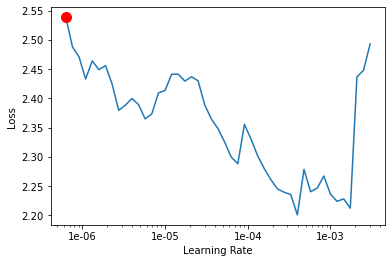

In [ ]:
#@title Find an optimal learning rate. This may take some time. { vertical-output: true, display-mode: "form" }
learn.lr_find()
learn.recorder.plot(suggestion=True)

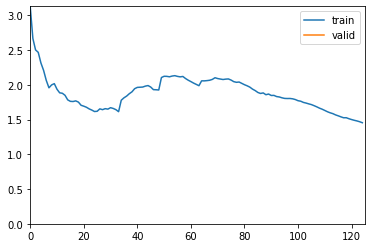

In [ ]:
cyc_len = 1 #@param {type:"integer"}
max_learning_rate = 1e-3 #@param {type:"number"}

learn.fit_one_cycle(cyc_len, max_learning_rate)

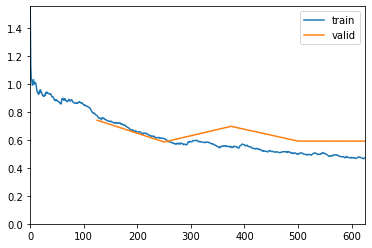

In [ ]:
cyc_len = 5 #@param {type:"integer"}
max_learning_rate = 1e-4 #@param {type:"number"}

learn.unfreeze()
learn.fit_one_cycle(cyc_len, max_learning_rate)

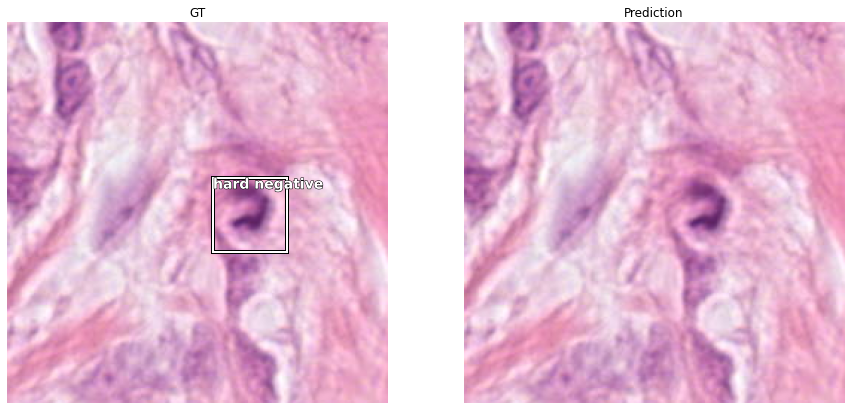

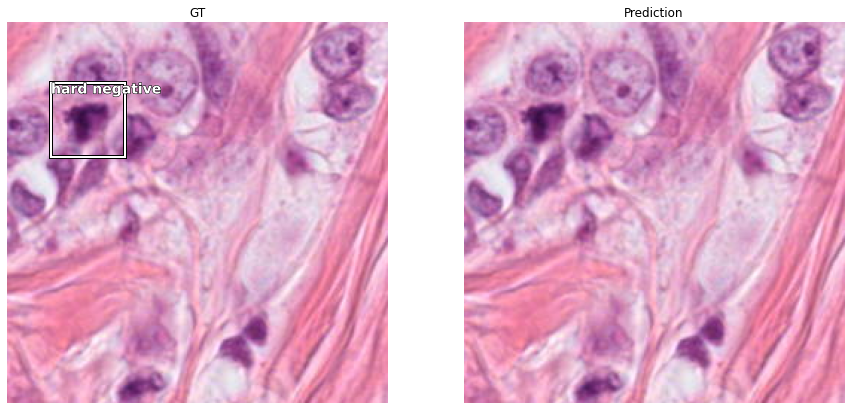

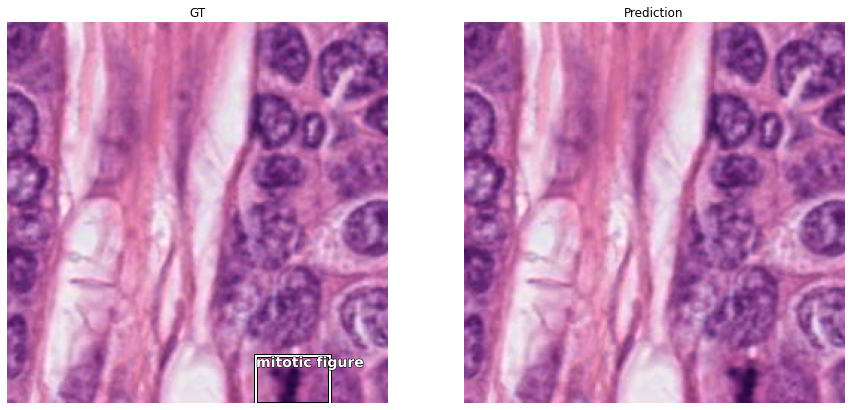

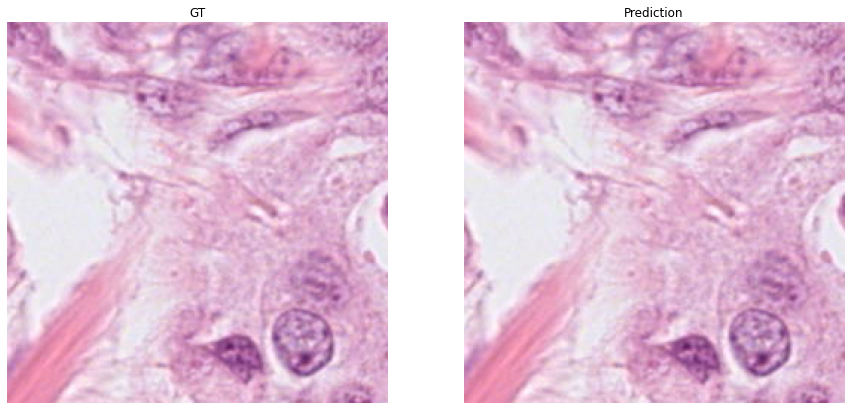

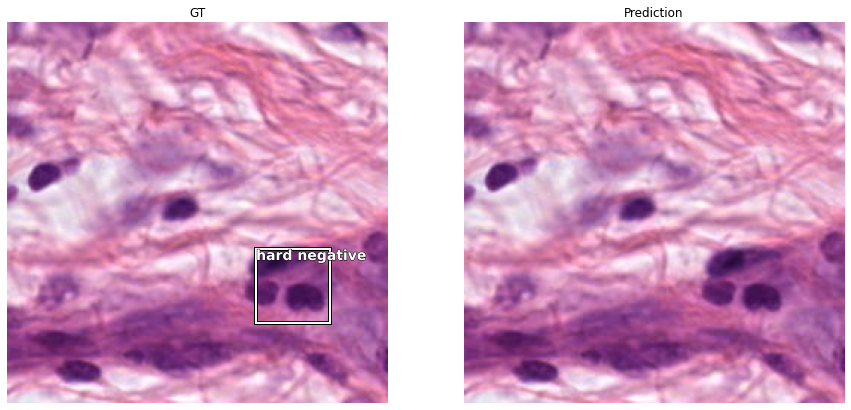

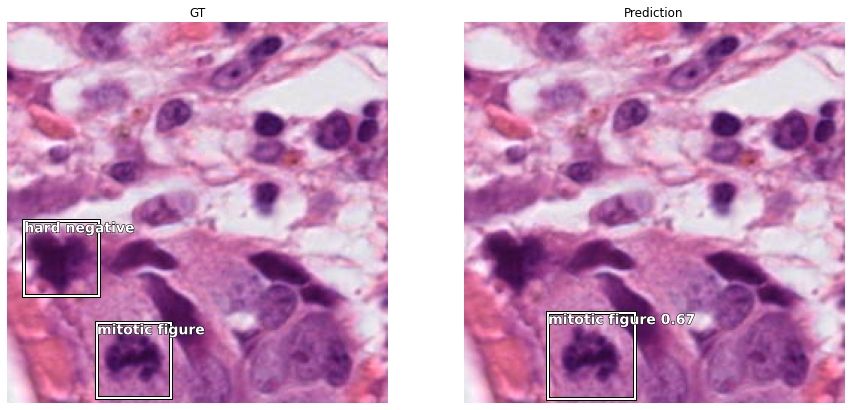

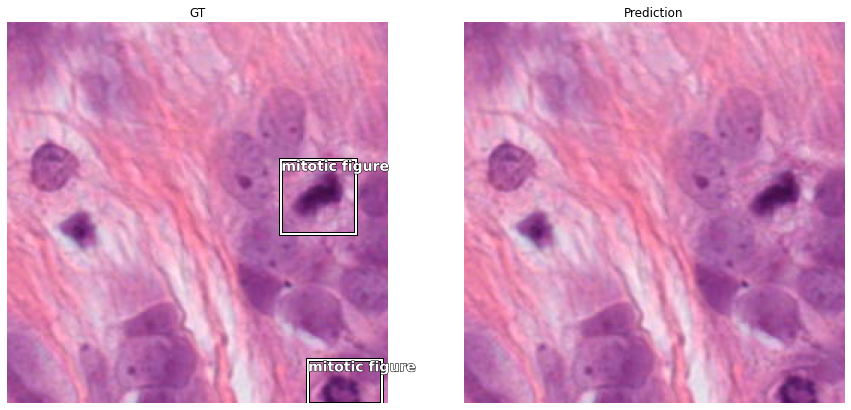

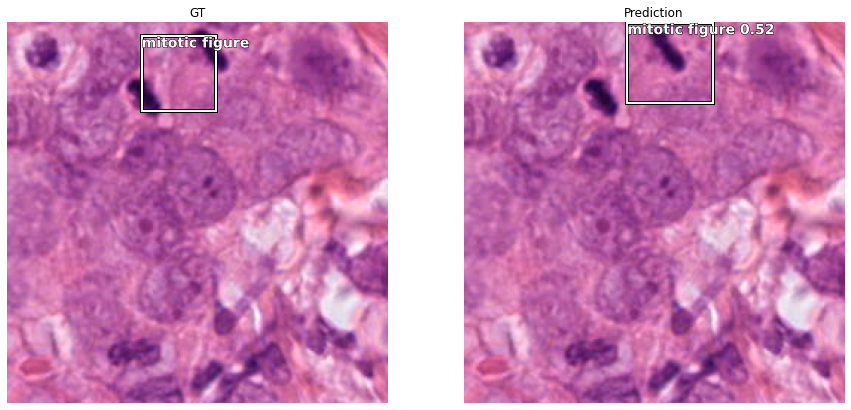

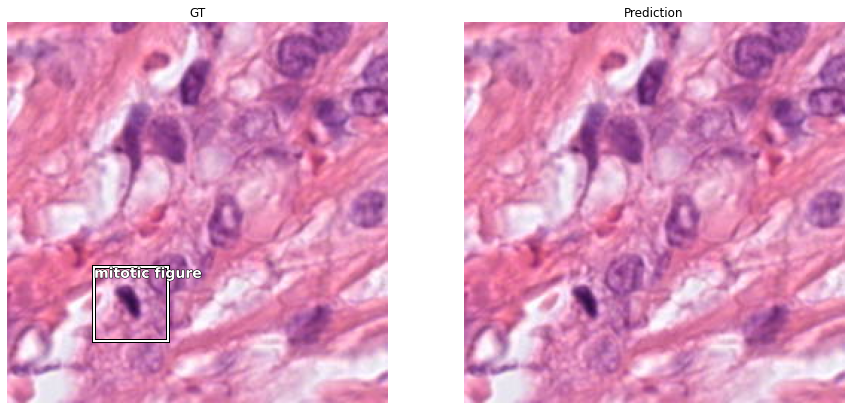

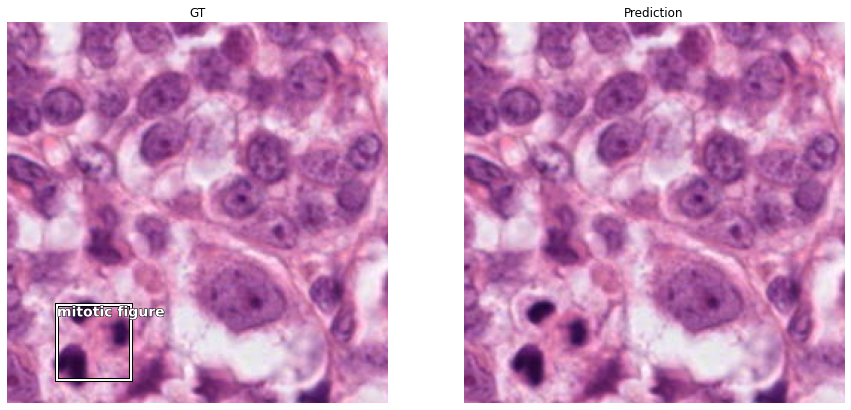

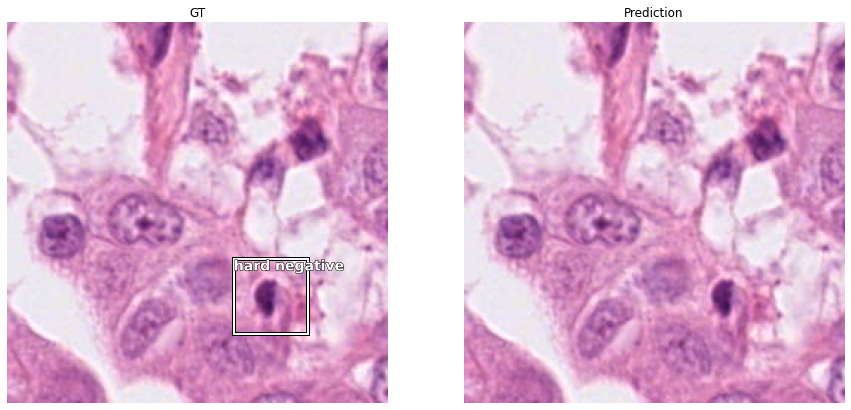

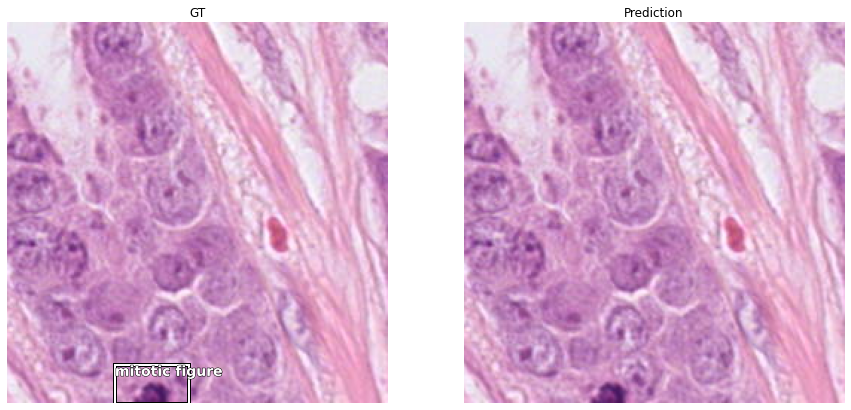

In [ ]:
detect_thresh = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.1}
nms_thresh = 0.2 #@param {type:"slider", min:0.1, max:1, step:0.1}
image_count=15 #@param {type:"integer"}

show_results_side_by_side(learn, anchors, detect_thresh=detect_thresh, nms_thresh=nms_thresh, image_count=image_count)

Please have in mind that the scanners of the test set are partially the same scanners of the training set, and partially different ones.

**We hope that you're now eager to work on the problem and participate in the 
challenge!**

We are looking forward to your clever solutions. See you on **MICCAI 2021**!

**The MIDOG 2021 team**

https://imi.thi.de/midog/